# Анализ доходности рублевых облигаций Московской Биржи
<img src="http://toplogos.ru/images/logo-moskovskaya-birzha.png" width ="500" height=500 >
<table style="width:30%">
    <tr>
        <th>Выполнил:</th>
        <td>Зыльков П.А.</td>
    </tr>
    <tr>
        <th>Руководитель:</th>
        <td>Зуев А.В.</td>
    </tr>
</table>

## Импорт библиотек

In [151]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sts
import chardet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None
%matplotlib inline

## Импорт данных 

In [152]:
file = 'rates 12052021.csv'

with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
    
df = pd.read_csv(file, encoding=result['encoding'], sep=';', header=1)

## Выбранные поля
<b>SECID</b> - Код ценной бумаги<br> 
<b>NAME</b> - Полное наименование<br>
<b>FACEVALUE</b> - Номинальная стоимость<br>
<b>FACEUNIT</b> - Валюта номинала<br>
<b>DURATION</b> - Дюрация<br>
<b>IS_QUALIFIED_INVESTORS</b> - Для квалифицированных инвесторов<br>
<b>HIGH_RISK</b> - Высокий риск<br>
<b>COUPONFREQUENCY</b> - Периодичность выплаты купона в год<br> 
<b>COUPONDATE</b> - Дата следующего купона<br>
<b>COUPONPERCENT</b> - Ставка купона, %<br>
<b>COUPONVALUE</b> - Сумма купона, в валюте номинала<br>
<b>COUPONDAYSPASSED</b> - Дней прошло после выплаты купона<br>
<b>COUPONDAYSREMAIN</b> - Дней осталось до выплаты купона <br>
<b>COUPONLENGTH</b> - Купонный период<br>
<b>MATDATE</b> - Дата погашения<br>
<b>PRICE</b> - Цена покупки, % от номинала<br> 
<b>PRICE_RUB</b> - Цена покупки<br>


In [153]:
df_sliced = df[['SECID', 'NAME','IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'FACEVALUE', 'FACEUNIT', 'DURATION', 'COUPONFREQUENCY', 'COUPONDATE', 'MATDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH', 'PRICE', 'PRICE_RUB']]

<i>Возьмем только рублевые и низкорисковые облигации, предназанченые <b>не</b> только для квалифицированных инвесторов</i>

In [154]:
df_rub = df_sliced[(df_sliced['FACEUNIT']=='RUB') & (df_sliced['IS_QUALIFIED_INVESTORS']==0) & (df_sliced['HIGH_RISK']==0)]

In [155]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1933 entries, 9 to 2219
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   1933 non-null   object 
 1   NAME                    1933 non-null   object 
 2   IS_QUALIFIED_INVESTORS  1933 non-null   int64  
 3   HIGH_RISK               1933 non-null   int64  
 4   FACEVALUE               1933 non-null   object 
 5   FACEUNIT                1933 non-null   object 
 6   DURATION                1392 non-null   float64
 7   COUPONFREQUENCY         1644 non-null   float64
 8   COUPONDATE              1930 non-null   object 
 9   MATDATE                 1926 non-null   object 
 10  COUPONPERCENT           1901 non-null   object 
 11  COUPONVALUE             1901 non-null   object 
 12  COUPONDAYSPASSED        1930 non-null   float64
 13  COUPONDAYSREMAIN        1930 non-null   float64
 14  COUPONLENGTH            1930 non-null   

## Подготовка данных

<i>Избавимся от неполных данных и приведем оставшиеся к валидному виду</i>

In [156]:
def convert(val):
    """
    Convert the string number value to a float
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','.')
    return float(new_val)

In [157]:
df_rub.dropna(subset=['COUPONPERCENT', 'COUPONFREQUENCY', 'MATDATE', 'COUPONVALUE', 'PRICE_RUB'], inplace=True)

df_rub['COUPONPERCENT'] = df_rub['COUPONPERCENT'].apply(convert)
df_rub['COUPONVALUE'] = df_rub['COUPONVALUE'].apply(convert)
df_rub['FACEVALUE'] = df_rub['FACEVALUE'].apply(convert)
df_rub['PRICE'] = df_rub['PRICE'].apply(convert)
df_rub['PRICE_RUB'] = df_rub['PRICE_RUB'].apply(convert)
df_rub['COUPONDATE'] =df_rub['COUPONDATE'].apply(pd.to_datetime)
df_rub['MATDATE'] = df_rub['MATDATE'].apply(pd.to_datetime)

## Кластеризация методом K-средних
<i>Признаки для кластеризации:<br>
    <ul>
        <li>Цена покупки</li>
        <li>Процент купонной доходности</li>
    </ul>

In [121]:
X = df_rub.iloc[:, [10, 16]].values

### Количество кластеров с помощью метода "локтя"

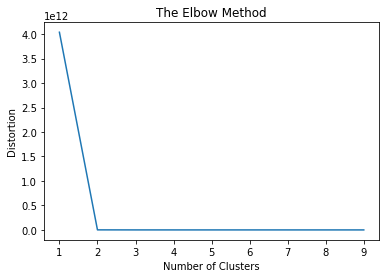

In [122]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(X)
    distortion.append(model.inertia_) 
    
plt.plot(K, distortion)

plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion');

---
<i>Следуя графику возьмем количество кластеров равное 2</i>

In [123]:
model = KMeans(n_clusters=2, random_state=12345)
y_means = model.fit_predict(X)

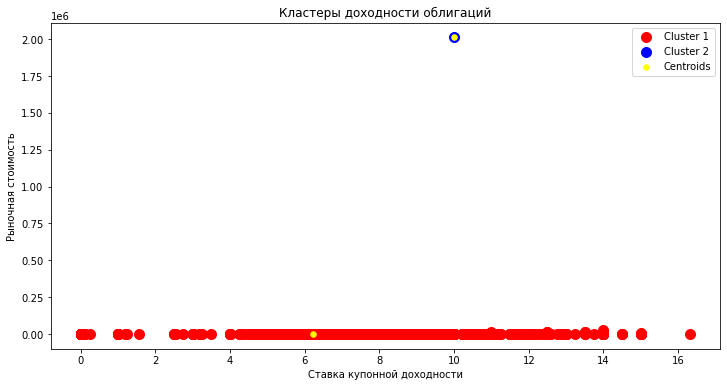

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=30, c='yellow', label='Centroids')

plt.title('Кластеры доходности облигаций')
plt.ylabel('Рыночная стоимость')
plt.xlabel('Cтавка купонной доходности')
plt.legend();

---
<i>На графике наглядно видно количетство выделенных кластеров рублевых облигаций (желтым выделены их центроиды):<br> 
- Cluster 1 - дешевые облигации (около 1000 руб.) с разнообразной купонной доходностью<br> 
- Cluster 2 - дорогие облигации, купонная доходность примерно в одном диапозоне значений, в данном случае она одна</i>

## Дополнение данных и анализ

<i>Добавим НКД и количество оставшихся купонов по каждой облигации</i>

In [125]:
df_rub['NKD'] = df_rub['FACEVALUE'] * (df_rub['COUPONPERCENT'] / 100) / df_rub['COUPONFREQUENCY'] * df_rub['COUPONDAYSPASSED'] / df_rub['COUPONLENGTH'] 
df_rub['COUPONLEFT'] = abs(df_rub['MATDATE'] - df_rub['COUPONDATE']).dt.days // df_rub['COUPONLENGTH'] + 1

### Функция расчета годовой прибыли

In [127]:
def profit_count(price, buy_price, nkd, coupon_price, coupon_left, end_date, last_date, last_remain):
    if buy_price >= price:
        earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price
    else:
        earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price - 0.13 * (price - buy_price)
    profit = ((earnings - buy_price) * 100 / buy_price) * 365 / (abs(end_date - last_date).days + last_remain)
    return profit

<i>Рассчитаем годовой процент прибыли по каждой облигации</i>

In [128]:
df_rub['PROFIT'] = df_rub.apply(lambda row: profit_count(row['FACEVALUE'], row['PRICE_RUB'], row['NKD'], row['COUPONVALUE'], row['COUPONLEFT'], row['MATDATE'], row['COUPONDATE'], row['COUPONDAYSREMAIN']), axis=1)

In [129]:
df_rub.head(10)

,SECID,NAME,IS_QUALIFIED_INVESTORS,HIGH_RISK,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
9,RU000A0JNYN1,Гор.Обл.Займ Москвы 48 в.,0,0,1000.0,RUB,379.0,2.0,2021-11-06,2022-11-06,6.00,29.92,152.0,30.0,182.0,100.1180,1026.1700,25.054945,3.0,4.675426
11,RU000A0JQ7Z2,"""Российские ЖД"" ОАО 19 обл.",0,0,1000.0,RUB,1020.0,2.0,2021-12-07,2024-08-07,7.85,39.14,121.0,61.0,182.0,103.1950,1057.9700,26.094780,6.0,4.878031
12,RU000A0JQ8V9,Мечел ПАО 04 обл.,0,0,50.0,RUB,64.0,4.0,2021-07-15,2021-07-15,8.00,1.00,27.0,64.0,91.0,253.9698,127.2849,0.296703,1.0,-342.384467
13,RU000A0JQAL8,ДОМ.РФ (АО) обл. сер. А14,0,0,1000.0,RUB,677.0,2.0,2021-05-15,2023-05-15,6.75,33.47,178.0,3.0,181.0,105.4370,1087.2900,33.190608,5.0,2.670211
14,RU000A0JQAM6,ДОМ.РФ (АО) обл. сер. А15,0,0,1000.0,RUB,2172.0,2.0,2021-09-15,2028-09-15,6.75,34.03,58.0,126.0,184.0,113.3870,1144.6000,10.638587,14.0,3.207730
15,RU000A0JQRD9,"""Российские ЖД"" ОАО 23 обл.",0,0,1000.0,RUB,1171.0,2.0,2021-07-22,2025-01-16,7.85,39.14,111.0,71.0,182.0,103.7870,1061.7400,23.938187,8.0,5.384733
16,RU000A0JQXG0,ДОМ.РФ (АО) обл. сер. А16,0,0,100.0,RUB,124.0,4.0,2021-06-15,2021-09-15,8.25,2.08,58.0,34.0,92.0,101.0875,102.3975,1.300272,2.0,3.456189
17,RU000A0JR4U9,Главная дорога АО об.сер. 03,0,0,1000.0,RUB,1315.0,1.0,2021-08-11,2028-10-30,4.00,39.89,184.0,180.0,364.0,97.8880,999.0400,20.219780,8.0,3.611611
18,RU000A0JR5F7,ДОМ.РФ (АО) обл. сер.А17,0,0,150.0,RUB,326.0,4.0,2021-07-15,2022-04-15,9.05,3.38,27.0,64.0,91.0,102.6520,154.9780,1.006937,4.0,4.727348
19,RU000A0JRDY3,ДОМ.РФ (АО) обл. сер.А18,0,0,700.0,RUB,18.0,4.0,2021-07-15,2023-07-15,5.25,9.16,27.0,64.0,91.0,100.9650,709.4750,2.725962,9.0,4.033288


## Графики

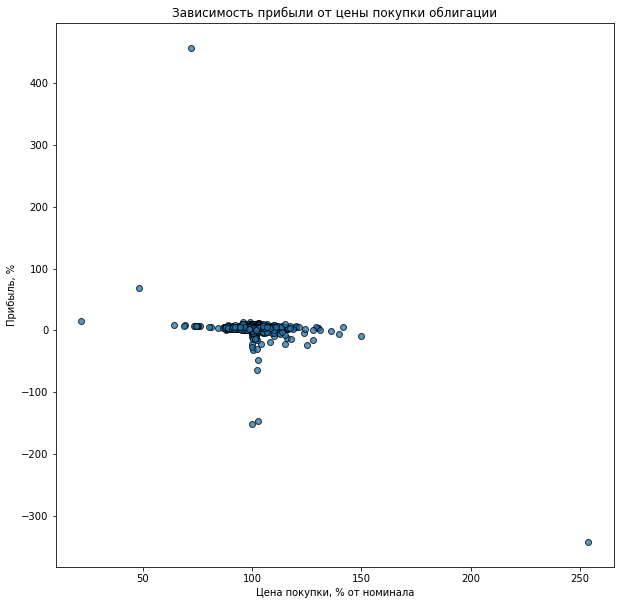

In [108]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(df_rub['PRICE'], df_rub['PROFIT'], edgecolor='black', alpha=0.75, linewidth=1)

plt.title('Зависимость прибыли от цены покупки облигации')
plt.xlabel('Цена покупки, % от номинала')
plt.ylabel('Прибыль, %')
plt.show()

---
<i>Смотря на график можно заметить очень интересный факт - чем <b>меньше</b> цена покупки облигации относительно её номинальной стоимости, тем <b>больше</b> доходность данной облигации</i>

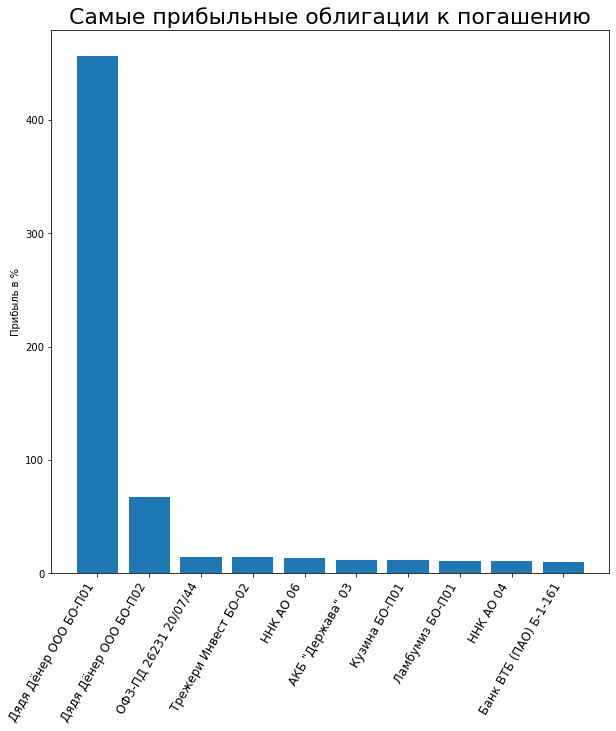

In [110]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=False).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые прибыльные облигации к погашению', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

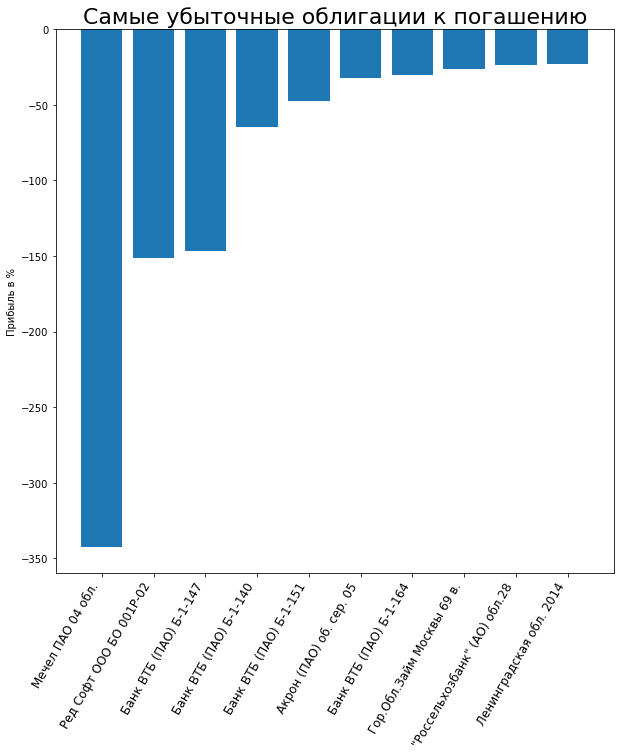

In [111]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=True).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые убыточные облигации к погашению', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

## Самые прибыльные облигации со сроком погашения год и более

In [132]:
end = pd.to_datetime("13MAY2022:00:00:00", 
                            format='%d%b%Y:%H:%M:%S')

df_rub[(df_rub['MATDATE'] >= end)].sort_values(by='PROFIT', ascending=False).head(20)

,SECID,NAME,IS_QUALIFIED_INVESTORS,HIGH_RISK,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
1410,RU000A101HQ3,Дядя Дёнер ООО БО-П02,0,0,10000.00,RUB,570.0,12.0,2021-04-06,2023-04-25,13.50,110.96,7.0,23.0,30.0,47.990,4824.890,26.250000,25.0,67.768193
2187,SU26231RMFS9,ОФЗ-ПД 26231 20/07/44,0,0,1000.00,RUB,NaN,2.0,2021-08-18,2044-07-20,0.25,1.25,84.0,98.0,182.0,21.633,216.910,0.576923,47.0,14.550526
341,RU000A0JWB59,"АКБ ""Держава"" 03",0,0,1000.00,RUB,NaN,2.0,2021-09-17,2036-02-29,15.00,74.79,54.0,128.0,182.0,102.989,1052.080,22.252747,30.0,12.192920
1148,RU000A100TL1,Кузина БО-П01,0,0,9320.00,RUB,384.0,12.0,2021-07-06,2023-08-26,15.00,114.90,4.0,26.0,30.0,102.590,9576.710,15.533333,27.0,11.534543
1094,RU000A100LE3,Ламбумиз БО-П01,0,0,10000.00,RUB,0.0,12.0,2021-06-06,2024-06-20,13.50,110.96,5.0,25.0,30.0,101.430,10161.490,18.750000,38.0,11.098301
266,RU000A0JVHH1,ТрансФин-М ПАО БО-39,0,0,1000.00,RUB,35.0,2.0,2021-09-06,2025-04-06,13.50,67.32,154.0,28.0,182.0,100.438,1061.340,57.115385,8.0,10.482076
949,RU000A1005T9,ФПК Гарант-Инвест БО 001P-05,0,0,840.00,RUB,569.0,4.0,2021-05-07,2024-05-04,12.00,25.13,37.0,54.0,91.0,99.961,849.892,10.246154,13.0,10.271558
1995,RU000A102LF6,Пионер-Лизинг БО-П04,0,0,1000.00,RUB,2093.0,4.0,2021-06-25,2030-12-13,12.00,29.92,47.0,44.0,91.0,99.988,1015.330,15.494505,39.0,10.263767
1822,RU000A102AB8,Завод КЭС 001P-02,0,0,1000.00,RUB,844.0,4.0,2021-07-29,2024-10-24,14.00,34.90,13.0,78.0,91.0,104.747,1052.460,5.000000,14.0,10.248037
1977,RU000A102KQ5,ТД РКС-Сочи 002Р-01,0,0,1000.00,RUB,814.0,4.0,2021-06-23,2023-12-20,12.50,31.16,49.0,42.0,91.0,100.838,1025.160,16.826923,11.0,10.211568
